In [59]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.io import output_notebook, export_svgs
from bokeh.models import Title, HoverTool, Legend, LinearColorMapper, ColorBar, BasicTicker, Range1d, Label, Div
from bokeh.layouts import row, column, gridplot
from math import pi
output_notebook()
%matplotlib inline

Loading BokehJS ...

# Expected Time vs. Actual Time

In this notebook we will respond the question on how to measure and to report the expected time vs. actual time differences. In particular, we will propose an indicator that is clear and simple enought to capture the differences between these two measures.

In [2]:
pick_drop = pd.read_pickle('data/pick_drop_data')
booking_data = pd.read_pickle('data/bookings_data')

In [3]:
pick_drop["actual_time_utc_berlin"].notnull().sum()

2110

In [4]:
((pick_drop["actual_time_utc_berlin"].notnull()) &  (pick_drop["type"] == "pickup")).sum()

1098

In [5]:
((pick_drop["actual_time_utc_berlin"].notnull()) &  (pick_drop["type"] == "dropoff")).sum()

1012

Checking our data, we notice that there are a total of 2110 observations in our `pick_drop` data set that have an actual time of pick up. Note that this can be further divided in pick ups and drops offs. 

A first thing we notice here is that there are more pick ups than closed services. In our exploratory analysis we saw that we had 1014 closed pick up services and 1012 closed drop off services. What could explain this difference?

In what follows, we show that the difference is related to the cases when the driver itself has cancelled the service. To prove this, we get first the cases of the `pick_drop` data set where there exist a pick up, an actual time and the service was cancelled. We compare the `booking_id` with that of the `booking_data` for the cases where the driver decided to cancel the service. We notice that there are no differences at all, meaning that the cancel pick ups with actual time corresponds to cases where driver cancelled the service.

In [6]:
bookings_pick_up_canceled = pick_drop[pick_drop["actual_time_utc_berlin"].notnull() &  
                                      (pick_drop["type"] == "pickup") & 
                                      (pick_drop["status"] == "cancelled")]
bookings_driver_cancelled = booking_data[booking_data['cancelled_by'] == 'driver']
set(bookings_pick_up_canceled['booking_id']).difference(set(bookings_driver_cancelled['booking_id']))

set()

### Should cancelled pick ups be part of the analysis?

While this might be a point for discussion, we think that cancelled pick ups should not be part of the expected time vs. actual time analysis. We believe that the cancelled pick ups by the driver might have other motivations (user was never in the place, user forgot to cancel service, etc) than waiting. 

In this sense, the actual vs. expected time analysis wants to deal with how the difference affect the service experience. If there was no service to the user to begin with and no waiting time, it is difficult to see how this has affected the quality of the service. We decide, therefore, to exclude these points from our analysis.

In [7]:
exp_act_time = pick_drop[(pick_drop["actual_time_utc_berlin"].notnull()) 
          & ~(pick_drop["status"] == "cancelled")].reset_index()

In [8]:
#Finding time differences
def diff(row,t1,t2):
    """
    t1: Timestamp object.
    t2: Timestamp oject.
    """
    d = row[t1]-row[t2]
    diff_seconds = d.total_seconds()
    return diff_seconds

In [9]:
exp_act_time.loc[:,"time_diff"] = exp_act_time.apply(diff, t1='actual_time_utc_berlin', 
                                                     t2='estimated_time_utc_berlin', axis=1)

In [10]:
def print_stats(df, column):
    total_hours_diff = df[column].sum() / (60*60)
    avg_total_hours_diff = df[column].sum() / len(exp_act_time)
    sd_total_hours_diff = df[column].std()
    print("Total difference (hours): {:.3f}".format(total_hours_diff))
    print("Average (seconds): {:.3f}".format(avg_total_hours_diff))
    print("Standard deviation (seconds): {:.3f}".format(sd_total_hours_diff))



In [11]:
print_stats(exp_act_time,"time_diff")

Total difference (hours): 31.382
Average (seconds): 55.762
Standard deviation (seconds): 254.066


In [12]:
#Passing time difference to minutes
exp_act_time["time_diff_min"] = exp_act_time["time_diff"]/60

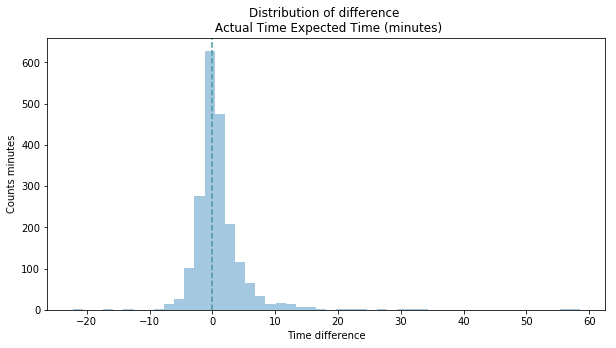

In [13]:
#Plotting distribution of expected vs. actual difference
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(exp_act_time["time_diff_min"], kde=False, ax=ax)
ax.set_xlabel("Time difference")
ax.set_ylabel("Counts minutes")
ax.set_title("Distribution of difference \n Actual Time Expected Time (minutes)")
ax.axvline(0, color="#44999E", linestyle='--');

Looking at the distribution of total seconds difference between actual time and expected time, we see that this has a somewhat of a bell shape. Note, however, that the distribution tends to be shifted towards the positive values. This explains why the total sum is positive (31 hours difference in total approx). 

As an additional, there are some outliers worth mentioning. For example, the case with the highest difference between both values is almost an hour: 58 minutes, 53 seconds.

The average difference between both measures is not bad. In total we have that approximately there is a 55 second differences. However, the standard deviation tells us that this distribution is quite spread. Therefore, it is important to understand well the cases when there is a mismatch between actual and expected time.

In [14]:
def get_thresholds_groups(df, column):
    df["time_thresholds"] = pd.cut(df[column], [-100,-7,-3,0,3,7,100])
    #Check that cut do not generate empty cells (so every observation is within a category)
    if df["time_thresholds"].isnull().sum() == 0:
        group_threshold = df.groupby("time_thresholds")['booking_id'].aggregate(lambda x: len(x) / len(df)).reset_index()
        group_threshold = group_threshold.rename(columns={"booking_id": "pct"})
        colors = ["#E43216", "#E4E02C", "#459E0F"]
        colors.extend(colors[::-1])
        group_threshold["colors"] = colors
        return group_threshold

def get_region_threshold_groups(df, column):
    colors_dict = {"#E43216":"red", "#E4E02C":"yellow", "#459E0F":"green"}
    region_group = df.groupby(column).agg({'pct': np.sum}).reset_index()
    region_group["thresholds"] = region_group["colors"].map(lambda x: colors_dict[x])
    region_group["thresholds"] = pd.Categorical(region_group["thresholds"], ["green", "yellow", "red"])
    #Getting extra index for easier plotting 
    region_group = region_group.sort_values(by="thresholds").reset_index()
    region_group["thresholds"] = region_group["thresholds"].astype(object)
    return region_group

In [15]:
def plot_horizontal_time_thresholds(df, plot_w, plot_h, pct_column, colors_column, title):
    
    p = figure(plot_width=plot_w, plot_height=plot_h)

    #Cases where actual time less than expected time
    perct_neg_acc = 0
    for i in list(range(0,3))[::-1]:
        p.hbar(y=1, height=0.3, left=-df[pct_column][i] + perct_neg_acc,
           right=perct_neg_acc, color=df[colors_column][i] )
        p.line(x=[perct_neg_acc, perct_neg_acc], y=[0.5, 1.5], line_width=2, color="#AAB2A5", line_dash="dashed")
        perct_neg_acc -= df[pct_column][i]
    
    #Cases where expected time less than actual time    
    perc_pos_acc = 0
    for i in list(range(3,6)):
        p.hbar(y=1, height=0.3, left=perc_pos_acc,
           right = df[pct_column][i] + perc_pos_acc, color=df[colors_column][i])
        p.line(x=[perc_pos_acc, perc_pos_acc], y=[0.5, 1.5], line_width=2, color="#AAB2A5", line_dash="dashed")
        perc_pos_acc += df[pct_column][i]
        
    p.y_range = Range1d(0, 2)
    p.add_layout(Title(text=title, align="center", text_font_size="10pt"), 
             "above")
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.yaxis.visible = False
    return p

In [16]:
def plot_total_pct_thresholds(df, plot_w, plot_h, index_col,  pct_column, color_column, title):

    source = ColumnDataSource(df)    
    hover = HoverTool(tooltips=[
        ("pct", "@"+ pct_column +"{(0.00%)}")
    ])

    total_perc = figure(plot_width=plot_w, plot_height=plot_h, tools=[hover])
    total_perc.add_layout(Title(text=title, align="center", text_font_size="10pt"), 
             "above")

    total_perc.vbar(x=index_col, top=pct_column, color=color_column, source= source, width=0.6)
    
    return total_perc

In [17]:
group_threshold = get_thresholds_groups(exp_act_time, "time_diff_min")
region_group = get_region_threshold_groups(group_threshold, "colors")

In [51]:
time_threshold = plot_horizontal_time_thresholds(group_threshold, 400, 400, 'pct', 'colors', "Rush/delays within time thresholds")
within_thresholds = plot_total_pct_thresholds(region_group, 400, 400, "index", "pct", "colors", "Total percentage within thresholds")
show(column(Div(text="<h1 style='margin-left:200px;margin-right:-400px;margin-bottom:18px;font-size:20px;\
                color:#7D7575'> Time thresholds for pick ups and drop offs </h1>"), row(time_threshold, within_thresholds)))


### Differences in pick ups / drop offs

Here we analyze the differences between pick ups and drop off. Evidently, there is a difference between actual time when we talk about pick ups and drop offs. Particularly, if the difference is significance for pick up it might be that the service will never be provided (e.g. could lead to cancellations).

To enter in this level of analysis we will calculate the differences for pick ups and drop offs respectively.


In [19]:
exp_act_time_pick_up = exp_act_time[exp_act_time["type"]=="pickup"].reset_index()
exp_act_time_drop_off = exp_act_time[exp_act_time["type"]=="dropoff"].reset_index()

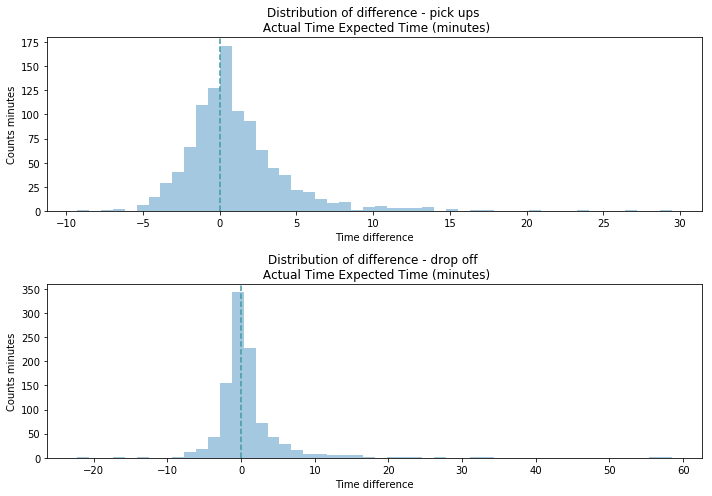

In [20]:
fig, ax = plt.subplots(2, figsize=(10,7))
sns.distplot(exp_act_time_pick_up["time_diff_min"], kde=False, ax=ax[0])
sns.distplot(exp_act_time_drop_off["time_diff_min"], kde=False, ax=ax[1])
ax[0].set_title("Distribution of difference - pick ups \n Actual Time Expected Time (minutes)")
ax[1].set_title("Distribution of difference - drop off \n Actual Time Expected Time (minutes)")
for ax in ax.flatten():
    ax.set_ylabel("Counts minutes")
    ax.set_ylabel("Counts minutes")
    ax.set_xlabel("Time difference")
    ax.axvline(0, color="#44999E", linestyle='--')
fig.tight_layout() 

In [21]:
print("Statistics for Pick ups")
print_stats(exp_act_time_pick_up,"time_diff")

Statistics for Pick ups
Total difference (hours): 18.453
Average (seconds): 32.789
Standard deviation (seconds): 208.060


In [22]:
print("Statistics for Drop offs")
print_stats(exp_act_time_drop_off,"time_diff")

Statistics for Drop offs
Total difference (hours): 12.929
Average (seconds): 22.973
Standard deviation (seconds): 292.788


Checking the distributions, we can see that the differences between actual and expected time for pick ups are more spread than that of drop off time. Also, while drop off tend to be more centered at 0, the pick up is more shifted towards positive values.

These differences are also clear when we see at the statistics: the differences in averages for both distribution is almost 10 seconds. The standard deviation for the drop off is a bit higher, presumably this could be due to the higher number of extreme values in this distribution.

In [23]:
threshold_pick_up =  get_thresholds_groups(exp_act_time_pick_up, "time_diff_min")
within_thresh_pick_up = get_region_threshold_groups(threshold_pick_up, "colors")
threshold_drop_off = get_thresholds_groups(exp_act_time_drop_off, "time_diff_min")
within_thresh_drop_off = get_region_threshold_groups(threshold_drop_off, "colors")

In [24]:
#Using plotting functions
time_threshold_pick_up_plot = plot_horizontal_time_thresholds(threshold_pick_up, 400, 300, 'pct', 'colors', 
                                                 "Rush/delays within time thresholds pick up")
within_thresholds_pick_up_plot = plot_total_pct_thresholds(within_thresh_pick_up, 400, 300, "index", "pct", "colors", 
                                              "Total percentage within thresholds pick up")
time_threshold_drop_off_plot = plot_horizontal_time_thresholds(threshold_drop_off, 400, 300, 'pct', 'colors', 
                                                 "Rush/delays within time thresholds drop off")
time_threshold_drop_off_plot.x_range = time_threshold_pick_up_plot.x_range
within_thresholds_drop_off_plot = plot_total_pct_thresholds(within_thresh_drop_off, 400, 300, "index", "pct", "colors", 
                                              "Total percentage within thresholds drop off")
threshold_pick_up_plots = row(time_threshold_pick_up_plot, within_thresholds_pick_up_plot)
threshold_drop_off_plots = row(time_threshold_drop_off_plot, within_thresholds_drop_off_plot)

show(column(Div(text="<h1 style='margin-left:200px;margin-right:-400px;margin-bottom:18px;font-size:20px;\
                color:#7D7575'> Time thresholds for pick ups / drop offs </h1>"),
            column(threshold_pick_up_plots, threshold_drop_off_plots)))


As observed in the previous plots, most of the ally shuttle pick ups and drop off occur within the 3 minute threshold. Note, still, that there is 20.5% pick ups that occur in the "yellow" area. From this, there approximately 14.5% happen because the pick up is delayed. This gives the company wiggle room to improve on. 

However, all in all, given the last update, the company seems to be doing well and mostly in the 3 minute zone. 

Note, however, that our analysis so far has been restricted to the last update of expected time shown to the user. There are reasons to believe that the closer the update to the actual pick up or drop off time, chances are that the differences between expected and actual time will not be significant. 

In what follows we will perform a more stringent analysis. We will determine what is the actual difference between first expected time shown to the user when he/she first booked a ride and the actual time ally shuttle showed up. There are important reasons to believe that customer experience changes when from the start they are given reliable waiting times. If the expected time changes drastically each update, this can affect service quality.

### First expected time vs. actual time 

In what follows we will perform the analysis of expected time when booking vs. actual time. This differences will show us how good is ally shuttle at keeping the first expected time it promises to the customers. The better these first expected times are calculated, the better the service will be. Also, from the operations point, it would lead to better scheduling and planning. 

In [25]:
first_pick_up = pick_drop.sort_values(by=["datetime_utc_berlin", "type"], 
                                           ascending=[True, False]).groupby('booking_id').agg(lambda x: x.iloc[0]).reset_index()
first_drop = pick_drop.sort_values(by=[ "type", "datetime_utc_berlin"], 
                                           ascending=[True, True]).groupby('booking_id').agg(lambda x: x.iloc[0]).reset_index()

In [26]:
first_pick_up_drop_long = pd.concat([first_pick_up, first_drop], ignore_index=True)

In [27]:
est_act_time_first = pd.merge(first_pick_up_drop_long, exp_act_time[['actual_time_utc_berlin', 'estimated_time_utc_berlin', 'type', 'status', 'booking_id']], 
        on=["type", "booking_id"], suffixes=["_first", "_actual"])

### Differences between first estimated time and last estimated time

Before looking at the difference between first estimated time and aactual time of the service, it is important to see if there are actually differences between the estimated times shown to the user. This will gives us an indication of how stable these estimated times actually are and what are the magnitude of their variation.

In [28]:
est_act_time_first.loc[:,"time_diff_first_last_est"] = est_act_time_first.apply(diff, t1='estimated_time_utc_berlin_actual', t2='estimated_time_utc_berlin_first', axis=1)
est_act_time_first["time_diff_first_last_est_min"] = est_act_time_first["time_diff_first_last_est"] / 60.0

In [29]:
print_stats(est_act_time_first,"time_diff_first_last_est")

Total difference (hours): 21.273
Average (seconds): 37.800
Standard deviation (seconds): 188.112


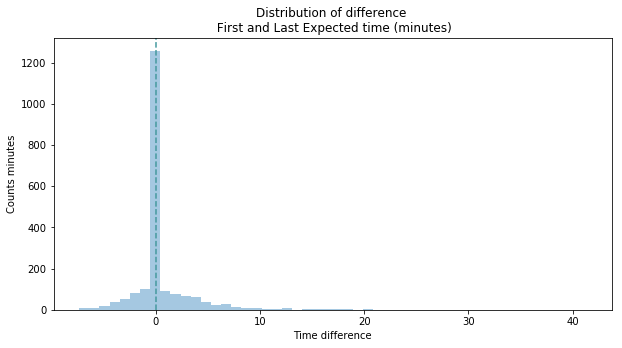

In [30]:
#Plotting distribution of firs expected vs. last expected
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(est_act_time_first["time_diff_first_last_est_min"], kde=False, ax=ax)
ax.set_xlabel("Time difference")
ax.set_ylabel("Counts minutes")
ax.set_title("Distribution of difference \n First and Last Expected time (minutes)")
ax.axvline(0, color="#44999E", linestyle='--');

The distribution plotted above shows that most of the distribution falls in the zero region. This means that, while there are differences due to updates in expected times, in general, there is a good quantity where there are no differences (meaning no updates) between first shown expected time and last expected time. In approximately 55% of the cases there is no difference between these two times. For the rest of the cases, we can see that cases above and below follow closely the same distribution. The only differences is that cases where the differences between these two times are positive (i.e., last expected time later than first expected time) shows more extreme values (maximum value 41 minutes difference).

### Diferences between first estimated time and actual time of service

In [31]:
est_act_time_first.loc[:,"time_diff_first_est_act"] = est_act_time_first.apply(diff, t1='actual_time_utc_berlin_actual', t2='estimated_time_utc_berlin_first', axis=1)
est_act_time_first["time_diff_first_est_act_min"] = est_act_time_first["time_diff_first_est_act"] / 60.0


In [32]:
print("Differences between Actual time and Last Expected Time")
print_stats(exp_act_time,"time_diff")
print("="*60)
print("Differences between Actual time and First Expected Time")
print_stats(est_act_time_first,"time_diff_first_est_act")

Differences between Actual time and Last Expected Time
Total difference (hours): 31.382
Average (seconds): 55.762
Standard deviation (seconds): 254.066
Differences between Actual time and First Expected Time
Total difference (hours): 52.655
Average (seconds): 93.562
Standard deviation (seconds): 323.879


For the sake of comparison, we have printed above the statistics of our previous analysis where we only compared last expected time vs. actual time. As it is possible to see, when taking the first expected time the user sees, the differences become larger. We can see almost a 20 hour difference between the total time. Also, the average increases approximately in 67% and the standard deviation also becomes wider.

In order to get a better picture of these results, we will plot the distribution of the differences.

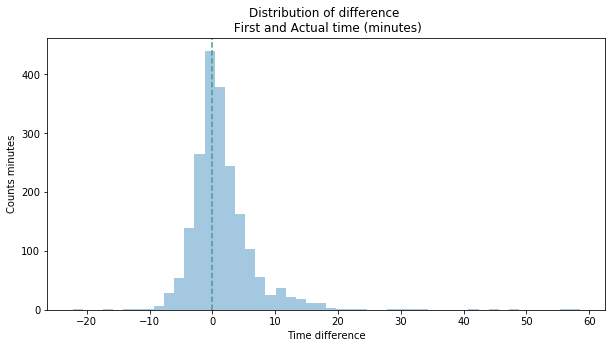

In [33]:
#Plotting distribution of firs expected vs. last expected
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(est_act_time_first["time_diff_first_est_act_min"], kde=False, ax=ax)
ax.set_xlabel("Time difference")
ax.set_ylabel("Counts minutes")
ax.set_title("Distribution of difference \n First and Actual time (minutes)")
ax.axvline(0, color="#44999E", linestyle='--');

In comparison to the last expected time, when considering the differences between first expected time and actual time we can see that the distribution gets wider. In particular, there is more density in values over the 10 minutes mark as before. 

In [34]:
threshold_est_act_time_first =  get_thresholds_groups(est_act_time_first, "time_diff_first_est_act_min")
within_threshold_est_act_time_first  = get_region_threshold_groups(threshold_est_act_time_first, "colors")

In [35]:
time_threshold_est_act_time_first = plot_horizontal_time_thresholds(threshold_est_act_time_first, 400, 400, 'pct', 'colors', 
                                                                "Rush/delays within time thresholds")
within_thresholds_est_act_time_first = plot_total_pct_thresholds(within_threshold_est_act_time_first, 400, 400, "index", "pct", "colors", "Total percentage within thresholds")
show(column(Div(text="<h1 style='margin-left:150px;margin-right:-450px;margin-bottom:18px;font-size:20px;\
                color:#7D7575'> Time thresholds for differences between expected times </h1>"), row(time_threshold_est_act_time_first, within_thresholds_est_act_time_first)))

In comparison to the differences with last expected time, when taking first expected time and actual service delivery we notice that the differences are more significant. Note that the green region (difference within 3 minutes) captures now 62.6% of services. Services in the yellow region (between 3-7 minutes) and red region (more than 7 minutes) grow. The red region, in particular, almost doubles. 

This shows that there is still space for improvement in terms of first expected time shown to the user. In particular, it will be important to reduce the cases in the red area because this can have an important effect on user's experience.

In what follows we perform the same analysis but separately for pick ups and drop offs.

### Differences in pick up / drop off first expected time vs. actual time

In [36]:
est_act_time_first_pick_up =  (est_act_time_first[est_act_time_first["type"] == "pickup"]).reset_index()
est_act_time_first_drop_off =  (est_act_time_first[est_act_time_first["type"] == "dropoff"]).reset_index()

In [37]:
#Calculating time differences for pick ups
est_act_time_first_pick_up.loc[:,"time_diff_first_est_act"] = est_act_time_first_pick_up.apply(diff, t1='actual_time_utc_berlin_actual', t2='estimated_time_utc_berlin_first', axis=1)
est_act_time_first_pick_up["time_diff_first_est_act_min"] = est_act_time_first_pick_up["time_diff_first_est_act"] / 60.0

In [38]:
print("Stats for difference between first expected time and actual pick up time\n")
print_stats(est_act_time_first_pick_up,"time_diff_first_est_act")

Stats for difference between first expected time and actual pick up time

Total difference (hours): 21.228
Average (seconds): 37.720
Standard deviation (seconds): 231.877


In [39]:
#Calculating time differences for drop offs
est_act_time_first_drop_off.loc[:,"time_diff_first_est_act"] = est_act_time_first_drop_off.apply(diff, t1='actual_time_utc_berlin_actual', t2='estimated_time_utc_berlin_first', axis=1)
est_act_time_first_drop_off["time_diff_first_est_act_min"] = est_act_time_first_drop_off["time_diff_first_est_act"] / 60.0

In [40]:
print("Stats for difference between first expected time and actual drop off time\n")
print_stats(est_act_time_first_drop_off,"time_diff_first_est_act")

Stats for difference between first expected time and actual drop off time

Total difference (hours): 31.427
Average (seconds): 55.843
Standard deviation (seconds): 394.421


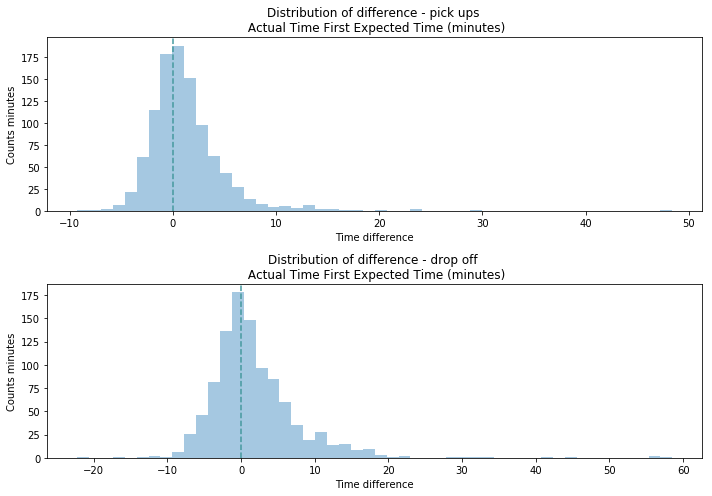

In [41]:
fig, ax = plt.subplots(2, figsize=(10,7))
sns.distplot(est_act_time_first_pick_up["time_diff_first_est_act_min"], kde=False, ax=ax[0])
sns.distplot(est_act_time_first_drop_off["time_diff_first_est_act_min"], kde=False, ax=ax[1])
ax[0].set_title("Distribution of difference - pick ups \n Actual Time First Expected Time (minutes)")
ax[1].set_title("Distribution of difference - drop off \n Actual Time First Expected Time (minutes)")
for ax in ax.flatten():
    ax.set_ylabel("Counts minutes")
    ax.set_ylabel("Counts minutes")
    ax.set_xlabel("Time difference")
    ax.axvline(0, color="#44999E", linestyle='--')
fig.tight_layout() 

Looking at the distributions and the statistics for pick ups and drop offs one can notice that the differences for actual time vs. first expected time are bigger for the drop off than pick ups. This is straightforward to understand. As drop off are farther ahead in the future, it is more difficult to predict than pick ups. Still doing better at predicting pick ups and drop offs would give the service reliability in terms of the expected time users need to wait for the complete service (pick up and drop off) to be conducted.

In [42]:
#Using plotting functions
threshold_first_pick_up =  get_thresholds_groups(est_act_time_first_pick_up, "time_diff_first_est_act_min")
within_thresh_first_pick_up = get_region_threshold_groups(threshold_first_pick_up, "colors")
threshold_first_drop_off = get_thresholds_groups(est_act_time_first_drop_off, "time_diff_first_est_act_min")
within_thresh_first_drop_off = get_region_threshold_groups(threshold_first_drop_off, "colors")

In [43]:
#Using plotting functions
time_threshold_first_pick_up_plot = plot_horizontal_time_thresholds(threshold_first_pick_up, 400, 300, 'pct', 'colors', 
                                                 "Rush/delays within time thresholds pick up")
within_thresholds_first_pick_up_plot = plot_total_pct_thresholds(within_thresh_first_pick_up, 400, 300, "index", "pct", "colors", 
                                              "Total percentage within thresholds pick up")
time_threshold_first_drop_off_plot = plot_horizontal_time_thresholds(threshold_first_drop_off, 400, 300, 'pct', 'colors', 
                                                 "Rush/delays within time thresholds drop off")
time_threshold_first_drop_off_plot.x_range = time_threshold_first_pick_up_plot.x_range
within_thresholds_first_drop_off_plot = plot_total_pct_thresholds(within_thresh_first_drop_off, 400, 300, "index", "pct", "colors", 
                                              "Total percentage within thresholds drop off")
threshold_first_pick_up_plots = row(time_threshold_first_pick_up_plot, within_thresholds_first_pick_up_plot)
threshold_first_drop_off_plots = row(time_threshold_first_drop_off_plot, within_thresholds_first_drop_off_plot)

show(column(Div(text="<h1 style='margin-left:150px;margin-right:-500px;margin-bottom:18px;font-size:20px;\
                color:#7D7575'> Time thresholds for pick ups / drop offs (first expected time)</h1>"),
            column(threshold_first_pick_up_plots, threshold_first_drop_off_plots)))

As already noticed in the distribution plots, first estimated times do worst for the drop offs. The regions within the pick ups are within our previous averages. However, in the drop offs we can see that barely more than 50% are within the 3 minutes of the first estimated time. Rides between 3-7 minutes make up approximately 30% of the total drop offs. 

## Differences between expected and actual time within hour/day

Here we will try to determine if there are specific hour/days for which the difference between expected and actual times are more relevant. As we saw that the differences are more pronunciated for the first expected time shown to the user, we will use this data set that will show us the upper bound of differences. The analysis for the last expected time should be easy to reproduce, if requested.

In [44]:
colors_dict = {"0":"red", "5":"red", "1":"yellow", "4":"yellow",  "2":"green", "3":"green"}
est_act_time_first["cat_codes"] = est_act_time_first["time_thresholds"].cat.codes.astype(str)
est_act_time_first["thresh_cat"] = est_act_time_first["cat_codes"].map(lambda x: colors_dict[x])
est_act_time_first
hour_est_act_time_first = est_act_time_first.groupby([pd.Grouper(freq='1h', key='datetime_utc_berlin'), "thresh_cat"]).agg(
    {'booking_id': "count"}).reset_index()
hour_est_act_time_first = hour_est_act_time_first.rename(columns={"booking_id":"count"})
hour_est_act_time_first["total"] = hour_est_act_time_first.groupby([pd.Grouper(freq='1h', key='datetime_utc_berlin')])["count"].transform(lambda x: x.sum())

In [45]:
hour_est_act_time_first["pct"] = hour_est_act_time_first["count"] / hour_est_act_time_first["total"]

In [46]:
#Pivoting for plotting purposes
hour_est_act_time_first = hour_est_act_time_first.pivot(index='datetime_utc_berlin', columns='thresh_cat')
hour_est_act_time_first.columns = ['_'.join(col) for col in hour_est_act_time_first.columns]

In [47]:
#Preparing and generating column for plotting
hour_est_act_time_first["date"] = hour_est_act_time_first.index.map(lambda x: x.strftime('%H H %a'))
hour_est_act_time_first["pct_yellow_plot"] = hour_est_act_time_first["pct_green"] +hour_est_act_time_first["pct_yellow"]
hour_est_act_time_first["pct_red_plot"] = hour_est_act_time_first["pct_yellow_plot"] +hour_est_act_time_first["pct_red"]

In [48]:
#Plotting hour day thresholds
source = ColumnDataSource(hour_est_act_time_first)
hover = HoverTool(tooltips=[
    ("pct. green", "@pct_green{(0.00%)}"),
    ("pct. yellow", "@pct_yellow{(0.00%)}"),
    ("pct. red", "@pct_red{(0.00%)}"),
    ])
p = figure(plot_width=800, plot_height=400, x_range=list(hour_est_act_time_first["date"]) ,x_axis_label="Dates", 
        y_axis_label="Percentage", tools=[hover])
#Plotting green first
p.vbar(x='date', width=0.7, top='pct_green', 
           color="#459E0F", source=source)
p.vbar(x='date', width=0.7, bottom='pct_green', top="pct_yellow_plot",
           color="#E4E02C", source=source)
p.vbar(x='date', width=0.7, bottom="pct_yellow_plot", top="pct_red_plot",
           color="#E43216", source=source)
p.add_layout(Title(text="Thresholds per hour/day", align="center", text_font_size="12pt"), 
             "above")
p.xgrid.visible = False
p.ygrid.visible = False
p.xaxis.major_label_orientation = pi/4
show(p)

In terms of days and hours we can see that there are certain times where ally incurs in more delays. For example, on Friday, at initial hours, when the demand was very high, we can observe that the yellow and red regions are bigger than the green region. 

Interestingly, we can also observe this trend in low peak turns. See for example Saturday at 14 hours. Even though this was a relatively low peak moment (see Exploratory analysis), we can see that ally still incurs in some delays. There might be different reasons why this might be the case. For example, perhaps the routes requested at that hour were farther away or, perhaps, there was a traffic jam that delayed all services. This can be a task for further analysis.

# Conclusions 

In this analysis we check the differences between expected and actual times in the allygator shuttle service provided by door2door. In particular, we offered a way of clearly communicating and understanding the differences between these two measures both quantitatively and visually.

Our indicator is inspired on a traffic light. We indicate three thresholds for actual pick ups and drop off times: within +/- 3 minutes of expected time (green light), +/- 3-7 minutes (yellow area) and >< 7 min (red light). The thresholds have been chosen based on author's customer experience. An improve upon this point could be to use actual consumer data to get thresholds based on their behavior.

We separated the analysis in two measures of differences. First, we measure the differences between last expected time reported to the user and actual time of service. According to our analysis, two thirds of the services are in the green area, in other words, they take place within 3 minutes of expected time. This conclusions, in general, hold when analyzing drop offs and pick ups separately, although we could observe that the yellow area grows to 20% for the pick ups.

As a next step we perform the same analysis but for the first expected time reported to the user when he/she request a ride. The logic behind this analysis is that user's experience with service may deteriorate if first expected time reported widely differs from actual time. Our analysis showed that while the difference do tend to be bigger than for the updated expected time, in general pick ups where still high in the green region. Drop offs do present more difference. In that case a bit more over 50% are caried out within 3 minutes. This gives considerable improving space for estimating and reporting the first drop off expectation.

Finally, we conducted the same analysis but for hour/days of the service. As it was expected, times where the demand is higher is also related to more differences in expected vs. actual time. However, we have also spotted some low peak hours where differences between times are also considerable. This demands further analysis.


